# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

/Users/vivek/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [92]:
# What kind of data do we have?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [3]:
# TODO: Total number of records
n_records = data.income.shape[0]

# TODO: Number of records where individual's income is more than $50,000
# find the set of unique values in income
print data.income.unique() # shows ['<=50K' '>50K']
n_greater_50k = (data.income == '>50K').sum()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = (data.income == '<=50K').sum()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100*float(n_greater_50k)/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

['<=50K' '>50K']
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

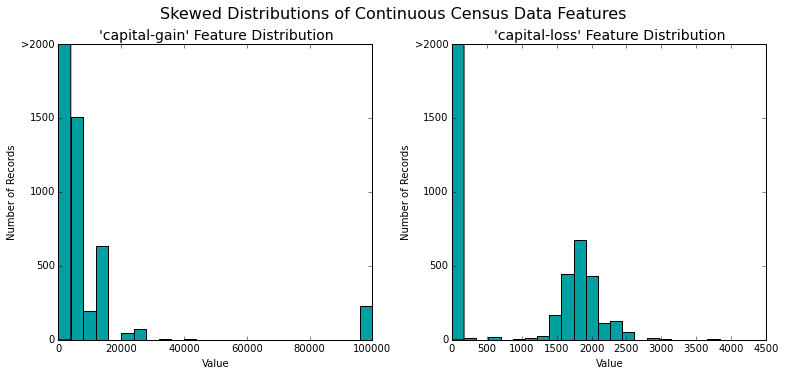

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

In [48]:
# What are the list of features?

list(features_raw.columns.values)

['age',
 'workclass',
 'education_level',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

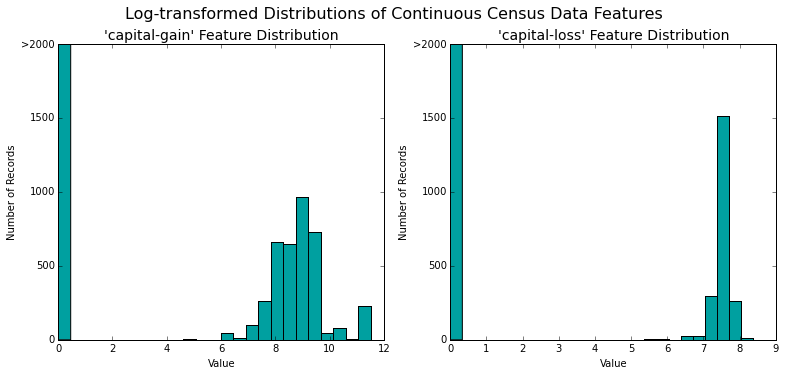

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

/Users/vivek/anaconda2/lib/python2.7/site-packages/ggplot/ggplot.py:192: RuntimeWarning: Setting "mpl.rcParams['axes.prop_cycle']=cycler(u'color', [u'#333333', u'#348ABD', u'#7A68A6', u'#A60628', u'#467821', u'#CF4457', u'#188487', u'#E24A33'])" raised an Exception: u'axes.prop_cycle is not a valid rc parameter.See rcParams.keys() for a list of valid parameters.'
  warnings.warn(msg, RuntimeWarning)
/Users/vivek/anaconda2/lib/python2.7/site-packages/ggplot/ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


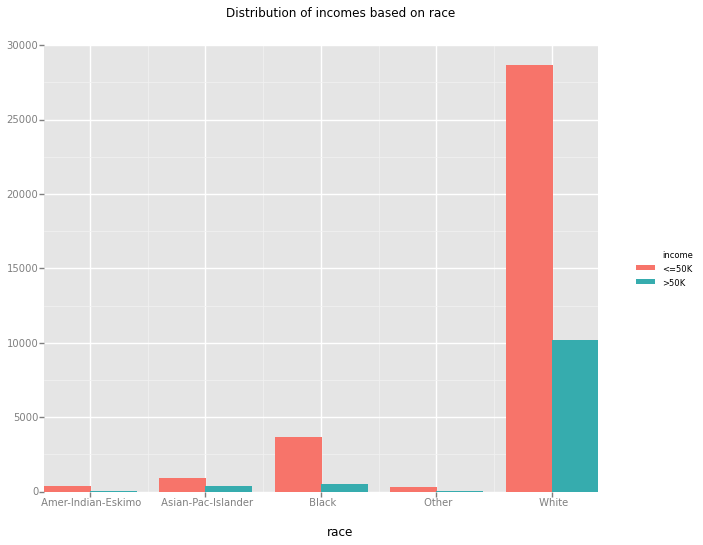

<ggplot: (279237345)>

In [6]:
# More visualizations (data exploration): 
# How do workclass education_level education-num
# marital-status occupation relationship race sex 
# hours-per-week play in to income 

from ggplot import *

# RACE Answer -> data dominated by whites, and also have a significant number of >50K people, 
# also slightly higher ratio of higher income earners than black community
ggplot(data, aes(x='race', fill='income')) + geom_bar() + ggtitle("Distribution of incomes based on race")


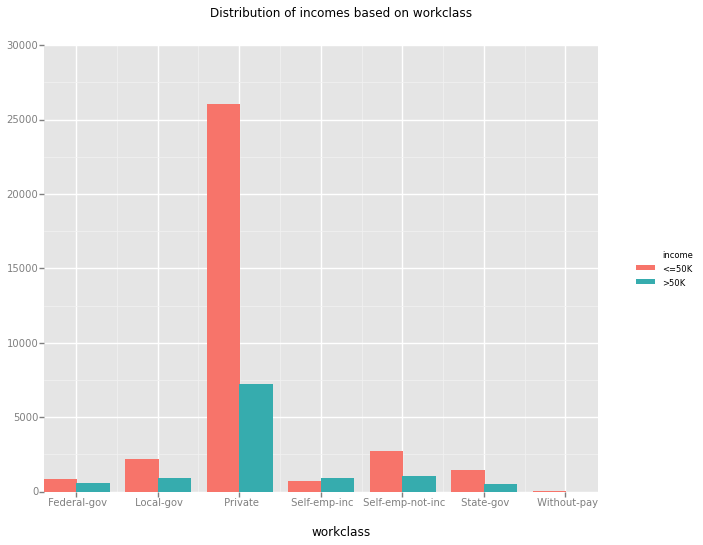

<ggplot: (280714517)>

In [7]:
# workclass Answer -> no clear trends, except that 
# self employed people seem to have more higher income earners
# also data is dominated by 'Private' individuals 
ggplot(data, aes(x='workclass', fill='income')) + geom_bar() + ggtitle("Distribution of incomes based on workclass")


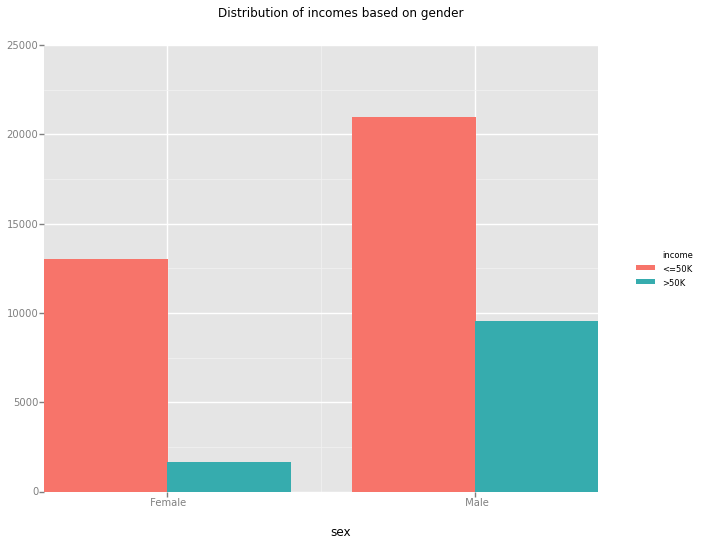

<ggplot: (281433973)>

In [8]:
# Sex Answer -> Males seem to have a much higher proportion of high-income earners than women
ggplot(data, aes(x='sex', fill='income')) + geom_bar() + ggtitle("Distribution of incomes based on gender")

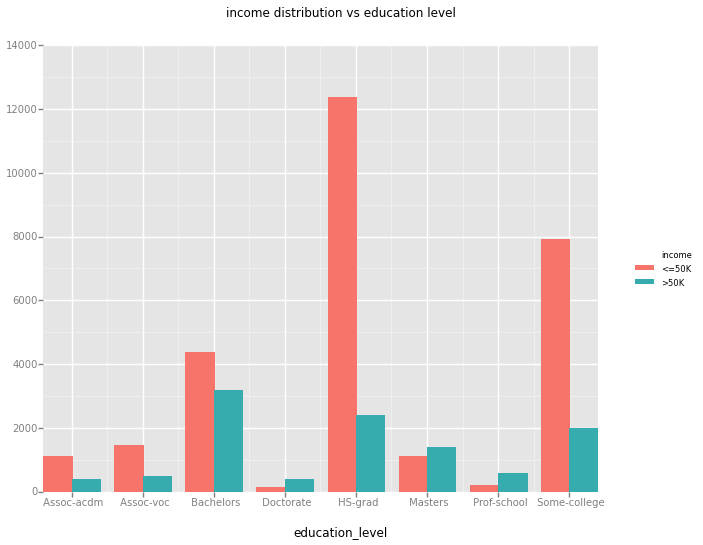

<ggplot: (281407809)>


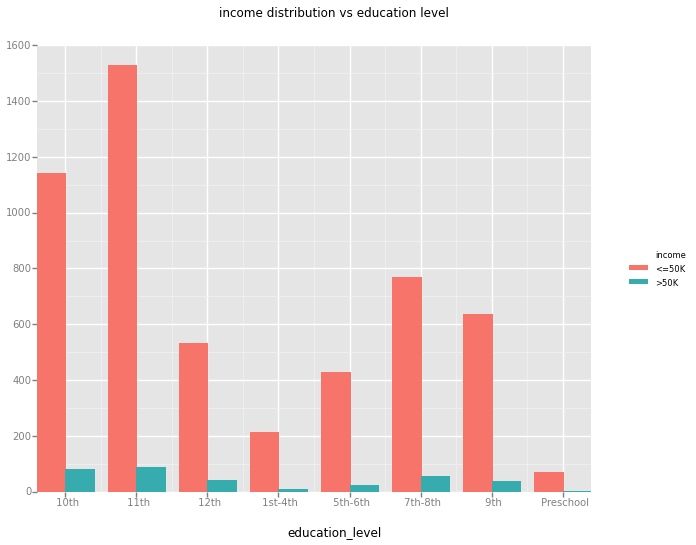

<ggplot: (279957301)>


In [9]:
# education-level Answer -> before high-school graduation, the proportion of high-income earners 
# is much smaller than after high-school graduation
# Only masters, doctorate and prof-school seem to tilt the income distribution towards higher earners


# plot all high school graduates
data1 = data[data['education_level'].isin([' Bachelors', ' HS-grad', ' Masters', ' Some-college',\
                                       ' Assoc-acdm', ' Doctorate', ' Assoc-voc', ' Prof-school'])]


print ggplot(data1, aes(x='education_level', fill='income')) + geom_bar() \
    + ggtitle("income distribution vs education level")
    #+ theme(axis_title_x=element_text("Bins", vjust=-0.1, size=28), axis_text_x=element_text(angle=45, size=20)) 
    
    
# plot pre-high school graduates
data2 = data[~data['education_level'].isin([' Bachelors', ' HS-grad', ' Masters', ' Some-college',\
                                       ' Assoc-acdm', ' Doctorate', ' Assoc-voc', ' Prof-school'])]

print ggplot(data2, aes(x='education_level', fill='income')) + geom_bar() \
    + ggtitle("income distribution vs education level")


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10c60f150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110f9eb50>], dtype=object)

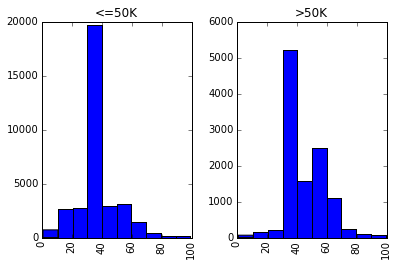

In [10]:
# hours-per-week Answer -> no clear trends. 
# mean hours of high earners is slightly higher. 
# no outliers

data['hours-per-week'].hist(by=data['income'])

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


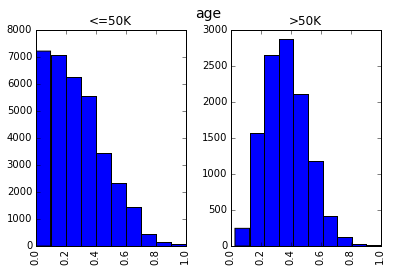

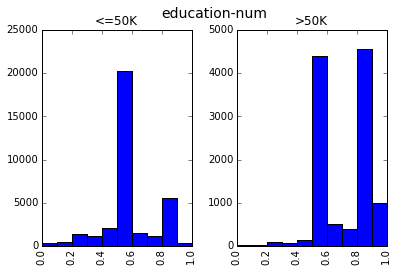

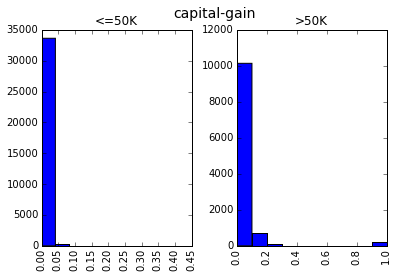

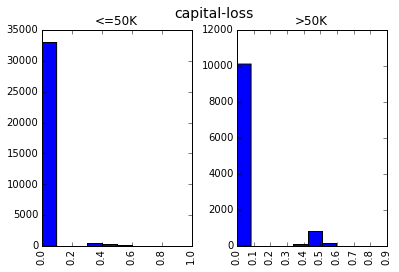

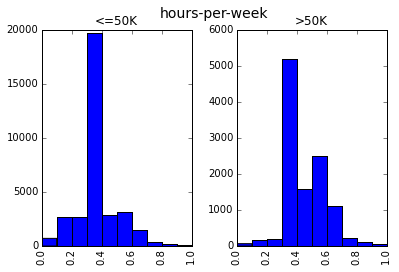

In [13]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
age                45222 non-null float64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [14]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
columnsToEncode = list(features_raw.select_dtypes(include=['object']))
features = pd.get_dummies(features_raw, prefix=columnsToEncode)

# Also add the numerical features
features[numerical] = features_raw[numerical]

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [15]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [24]:
# TODO: Calculate accuracy
from sklearn.metrics import accuracy_score, fbeta_score

income_predict = np.ones(len(income))
accuracy = accuracy_score(income, income_predict)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(income, income_predict, beta=0.5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

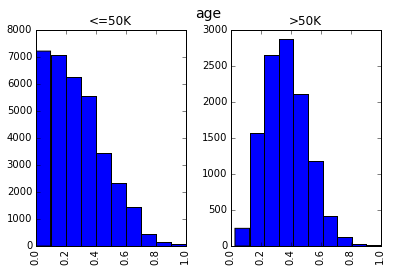

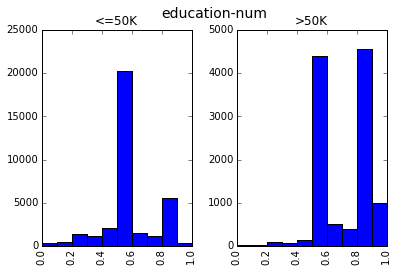

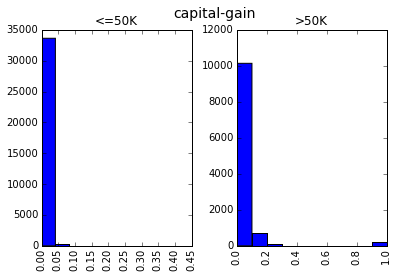

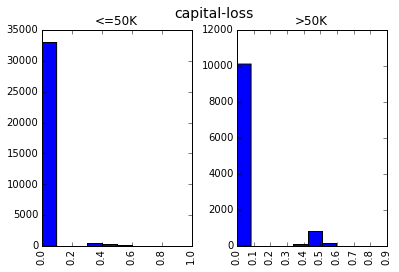

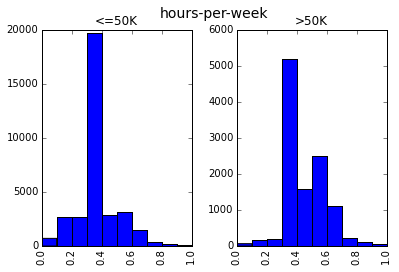

In [20]:
# Plot histogram of all numerical features in order to understand which model might best fit the data
import matplotlib.pyplot as plt

for i,feature in enumerate(numerical):
    
    features_raw[feature].hist(by=income_raw)
    plt.suptitle(feature, fontsize=14)


# **Answer: **

## Model Selection

### Eliminating options
We're **not using**:

1) Gaussian Naive Bayes, as the numerical features are not Gaussian in shape (see figures just above)

2) K-Nearest Neighbors requires defining a distance function, which is not obvious in this case

3) Stochastic Gradient Descent Classifier, as we don't have **that** high a number of training examples (100M+)

***

We are **unclear** 

1) if using the following would lead to high precision because **the data might not be linearly separable**

- Logistic regression or SVM (linear kernel)

***

The **remaining models** are:

1) Decision trees

2) Ensemble methods
- Random forests, AdaBoost, Gradient Boosting are likely to prevent overfitting and fit fairly complex boundaries

3) SVM with non-linear kernels
- say Gaussian kernel

***

### Final decision for model selection
Between all of these, I'd chose the following 3, to maximize odds of getting a high precision classifier:

1) **Random forests** 
* **Industry Application**: 3D imaging (Microsoft Kinect) 

* **Strengths**: can represent complex decision boundaries with low overfitting. Quite fast to train.

* **Weakness**: Query time might be slow for large forests. Results might not be as easy to interpret as a decision tree

* **Fit with Data**: we don't know the shape of the decision boundary. A random forest would be able to represent complex unknown shapes. the ensemble nature could potentially lead to high precision

2) **AdaBoost**
* **Industry Application**: Customer Service automation. Speech recognition and automatic classification to sales vs tech support.

* **Strengths**: Fast, low overfitting. Minimal parameter tuning (selection of weak learner and number of boosting cycles)

* **Weakness**: Might not work for multi-class classification

* **Fit with Data**: useful because it doesn't assume anything about data (linear separability, Gaussian noise etc.)


3) **SVM with Gaussian kernel**
* **Industry Application**: Self Driving cars (Road/lane detection), Classification of Microarray Gene Expression Data

* **Strengths**: High-robustness due to large margin nature, can include domain knowledge by engineering the kernel (similarity function)

* **Weakness**: Choosing the correct kernel might not always be obvious. It is also very slow for huge training sets 

* **Fit with Data**: might provide a robust large margin classifier with high precision

* **References**: https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [35]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


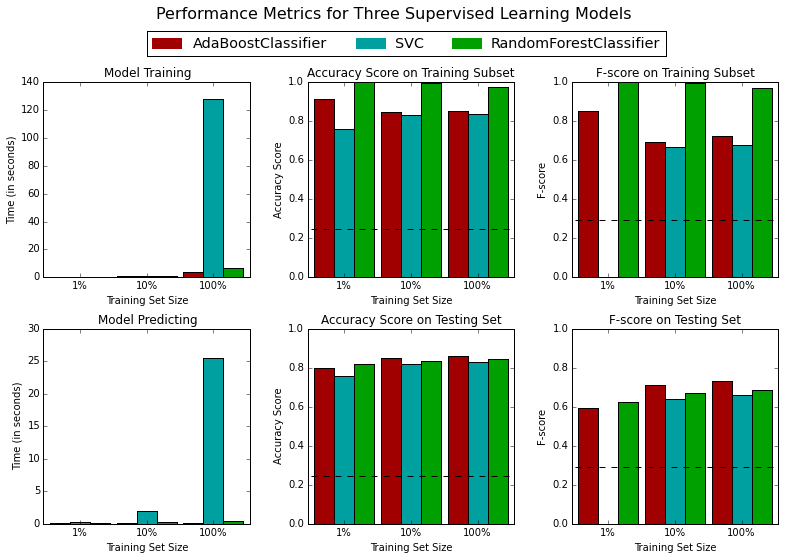

In [36]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm


# TODO: Initialize the three models
clf_A = RandomForestClassifier(n_estimators=100)
clf_B = AdaBoostClassifier(n_estimators=100)
clf_C = svm.SVC()  # default is rbf kernel

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(1.0/100*X_train.shape[0])
samples_10 = int(10.0/100*X_train.shape[0])
samples_100 = int(100.0/100*X_train.shape[0])

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

Of the 3 models, the results indicate that I should chose **the AdaBoost classifier** because it's:

- **prediction accuracy and F-score** with the test set is the **highest** 
- **training and prediction times** are the **lowest**

Even with the preliminary run, we get a prediction accuracy of ~85% which is ~4X the naive predictor accuracy. Furthermore, the algorithm suits this data as it does not require any specific structure of the data (Gaussian, linearly separable etc.) for it to work. It can represent very non-linear boundaries.

**However, I chose to optimize the RandomForestClassifier** as in sklearn's GridSearchCV implementation, it is more tunable. Furthermore, the training, testing times are almost as low as AdaBoost. Also the accuracy and F-Score are almost as high as AdaBoost. So my hope is that the tunability of the model will improve it's performance a lot more. 


### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

The RandomForestClassifier works by averaging the classification results of an "ensemble" of decision trees. This helps increase prediction accuracy, prevent overfitting and makes the algorithm fast. Each decision tree is built by  1) using a random subset of the training data, 2) each decision node split is based on a random subset of features. Finally the classification probabilities are averaged over the various trees. 



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [39]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[33,100,330], 'min_samples_split':[2, 10, 50], 'max_features': [4,8,16]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8377
F-score on testing data: 0.6715

Optimized Model
------
Final accuracy score on the testing data: 0.8629
Final F-score on the testing data: 0.7342


In [43]:
# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8377
F-score on testing data: 0.6715

Optimized Model
------
Final accuracy score on the testing data: 0.8629
Final F-score on the testing data: 0.7342


----
### WHAT ARE THE PARAMETERS OF THE OPTIMIZED MODEL

The parameter search has led to max_features and n_estimators to the high end of our range, 
which is expected as these are likely lower overfitting and hence minimize cross validation error. 
Also min_samples_split is at the high end of our range, which is also expected to lower overfitting.

In the future, we might want to tradeoff max_features with n_estimators, by choosing fewer features to split with and more trees, in order to speed up the algorithm.

In [45]:
grid_fit.best_params_

{'max_features': 16, 'min_samples_split': 50, 'n_estimators': 330}

----
### WHAT MORE CAN WE DO TO IMPROVE THE MODEL?

Plot learning curves to understand if a more complex model, or more data might help

**Answer** 

The learning curves show that the model performance saturates after about 10,000 training samples and that it has a fairly high accuracy (~80%). This indicates that **this model has relatively low bias, low variance model**. We might try to **make the model more complex**, perhaps by having deeper trees (or more complex models such as neural nets) and using data beyond the 10,000 data points to try to reduce the variance of the model. 

In [91]:
## Compute the learning curves

import sklearn.learning_curve as curves
from sklearn.cross_validation import ShuffleSplit
from sklearn.base import clone

""" Calculates the performance of model with varying sizes of training data.
    The learning and testing scores for the model are then plotted. """

classifier = clone(best_clf)

X = features
y = income

# Create 10 cross-validation sets for training and testing
cv = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.2, random_state = 0)

# Generate the training set sizes 
train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 5)).astype(int)

# Calculate the training and testing scores
sizes, train_scores, test_scores = curves.learning_curve(classifier, X, y, \
    cv = cv, train_sizes = train_sizes)

# Find the mean and standard deviation for smoothing
train_std = np.std(train_scores, axis = 1)
train_mean = np.mean(train_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)

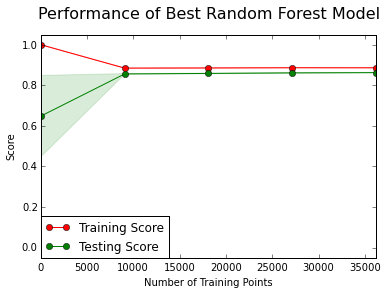

In [93]:
 # Plot the learning curves
# Create the figure window

fig = plt.figure()

# Subplot the learning curve 
plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
plt.fill_between(sizes, train_mean - train_std, \
    train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(sizes, test_mean - test_std, \
    test_mean + test_std, alpha = 0.15, color = 'g')

# Labels
plt.title('Performance of Best Random Forest Model', fontsize = 16, y = 1.05)
plt.xlabel('Number of Training Points')
plt.ylabel('Score')
plt.xlim([0, X.shape[0]*0.8])
plt.ylim([-0.05, 1.05])

# Visual aesthetics
plt.legend(loc='best', borderaxespad = 0.)
fig.show()

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.2478           |     0.8377        |   0.8629        |
| F-score        |    0.2917           |     0.6715        |   0.7342        |



**Answer: **

Both the supervised learing models (unoptimized and optimized) perform much better than the naive benchmark. 

Optimization of the Random forest model parameters leads to a further 3% increase in accuracy and an increase of 6% in the F-score, indicating that the precision of predicting people >50K is higher than 73%. (In fact, setting beta ~ 0 in the optimized model leads to an F-score of 0.7655, which is essentially the precision, a 7% increase over the 0.69 precision of the unoptimized model.)

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

The 13 features in the model are: 'age', 'workclass', 'education_level','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week' and 'native-country'

We are looking for the most predictive features, which mathematically is argmax feature of (information gain | feature) = I(0) - I(with feature) ~ -I(with feature) ~ sum of p x log(p) over the subsplits with the feature. 

#### I would expect the top 5 features that influence income to be:
1) **Occupation** - most direct indicator of your income (e.g. the chance of a physician's income to be higher than 50K is much higher than that of a food service professional)

2) **Sex** - Gender also has a clear effect as we can see (from the above charts) that females have a much smaller % of high-income earners than males. So Sex should have a lot of information.

3) **Race** - in our exploration above (see charts), we saw a clear indication that whites are statistically expected to earn more. P(high-income | Race) does vary quite a bit between blacks and whites which form the majority of the sample. So I expect race to have quite some information.

4) Similarly **education level** too has some good information as high-school graduation is a clear separator between low and high income earners. 

5) We might expect **Age** to play quite an important role as a bell curve (increases beyond your twenties and decreases after your fifties as you get closer to retirement). However, in terms of earning >50K, it may or may not matter much depending on your occupation, education level etc. That's why I've ranked it last.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

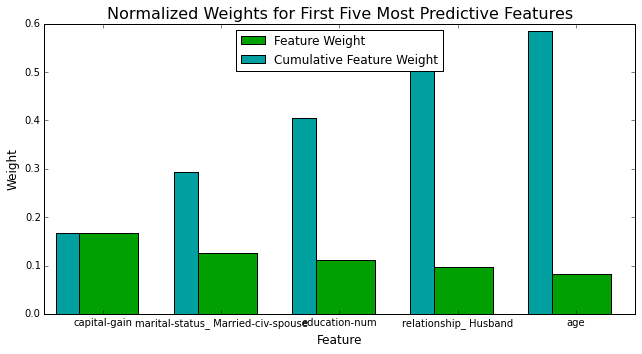

In [50]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# Just use the Random forest classifier from earlier

# TODO: Train the supervised model on the training set 

# Use the optimized model

# TODO: Extract the feature importances
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [57]:
# print all feature and their importances
for row in zip(features, importances):             
    for el in row:         
        print el, 
    print

 age 0.0824680591304
education-num 0.112143507408
capital-gain 0.166373038967
capital-loss 0.0472488829881
hours-per-week 0.0532676493729
workclass_ Federal-gov 0.00468501932736
workclass_ Local-gov 0.00315907774538
workclass_ Private 0.00468293563167
workclass_ Self-emp-inc 0.00475867783897
workclass_ Self-emp-not-inc 0.00748928703047
workclass_ State-gov 0.00239783830269
workclass_ Without-pay 7.35309284697e-05
education_level_ 10th 0.00103643560102
education_level_ 11th 0.0016015350749
education_level_ 12th 0.000450896130352
education_level_ 1st-4th 0.000104573848431
education_level_ 5th-6th 0.000471508245611
education_level_ 7th-8th 0.00156747965879
education_level_ 9th 0.000747297500988
education_level_ Assoc-acdm 0.00157698476566
education_level_ Assoc-voc 0.00167493974695
education_level_ Bachelors 0.0190335511026
education_level_ Doctorate 0.00287552271856
education_level_ HS-grad 0.00767029421547
education_level_ Masters 0.0102129243226
education_level_ Preschool 3.88451003242

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

The results show that capital gain, marital status (whether you have a spouse or not), number of years of education, age (experience) and relationship (husband or not) are the most important features. 

### Features I (almost) correctly predicted would be important: 
1) **Number of years of education** is related to education level. Also the  importance algorithm favors continuous inputs more than categorical ones because categotical variables are split down in to many variables, cutting down the contribution of each category to the importance.

2) **Relationship (husband or not)** is a feature that convolves **sex** (male) and **marital status** (married) in a way different than I had originally anticipated

3) **Age** is anticipated as an indicator of experience

### Features I missed: 
1) **Capital gain**: I did not think about this initially, but it clearly makes sense as an indicator of income.

2) **Marital status (with spouse)**: This is still not obvious to me. It could be that people with high income tend to be married more often.


### Features that turned out to be not so important
1) **Race** turns out to matter not so much, probably because the dataset is so hevily skewed towards whites that race might only provide minimal information.

2) **Occupation** didn't turn out in the top 5. One reason is that it is a categorical variable one-hit-encoded in to many binary variables. Adding all the weights within occupation comes out to 0.086 which is similar to the importance of age. However, other variables matter a lot more, probably reflecting my own biases. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [71]:
# Import functionality for cloning a model
from sklearn.base import clone

# In order to make a direct comparison, I'd like to use a reduced feature space 
# with the top 16 most important features because our optimized random tree has max_features = 16

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:16]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:16]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8629
F-score on testing data: 0.7342

Final Model trained on reduced data
------
Accuracy on testing data: 0.8575
F-score on testing data: 0.7211


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The accuracy and F-score are within ~1% of each other with the reduced feature set. 

So, if training time was a concern, I'd certainly consider using data with a reduced feature set. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.